In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
import tensorflow as tf


def drop_FF(df,features):
    list_1=list(features["col_name"][:20])
    for i in(list_1):
        df=df.drop(i,axis=1)
    return df
def get_FF(df,features):

    list_1=list(features["col_name"][:20])
    list_1.append('Label')
    ds=pd.DataFrame()
    ds=df[list_1]
    return ds

def get_real_data(data_path):
    df=pd.read_csv(data_path)
    df=df.loc[df["Label"]==0]
    df=df.iloc[:8000]
    df.drop("Label",axis=1)
    df["Label"]=0
    return df

def get_fake_data(data_path):
    df=pd.read_csv(data_path)
    df["Label"]=1
    return df

def get_combined_data(real_df,fake_df):
    return pd.concat([real_df, fake_df], axis=0)
def data_split(df,test_size = 0.3):
    
    y=df.Label
    X=df.drop(columns=["Label"])

    
    labels=y.unique()
    classes=y.nunique()


    print(X.shape)
    print("number of Label", classes)
    print("instances per label\n", y.value_counts())
    print("label",labels)
    
    # split the dataset into (100-(test_size*100)%) for training and (test_size*100)% for testing
    X_train , X_test, y_train , y_test = train_test_split(X,y, random_state=42 , stratify=y, shuffle=True,test_size=test_size)


    print("after spliting the data :\n")
    print("training data length:", len(X_train))
    print("test data length:", len(X_test))

    return X_train , X_test, y_train , y_test

def pre_processing(X_train , X_test, y_train , y_test):

    scaler= MinMaxScaler()
    le = LabelEncoder()

    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)

    # print("intances per label in training set \n",y_train.value_counts())
    y_train=le.fit_transform(y_train)

    # print("intances per label in test set \n",y_test.value_counts())
    y_test=le.fit_transform(y_test)

    print(X_train.shape)
    print(X_test.shape)

    y_train = np.asarray(y_train).astype("float32").reshape((-1,1))
    y_test = np.asarray(y_test).astype("float32").reshape((-1,1))
    

    # reshape input data to LSTM format [samples , time_steps, features]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    # print(f"shape of X_train:", X_train.shape)
    # print(f"shape of X_test:", X_test.shape)

    return X_train , X_test, y_train , y_test

def load_models(model_path):
    model = tf.keras.models.load_model(model_path)
    # Check its architecture
    print(model.summary())
    model.compile(loss="sparse_categorical_crossentropy", optimizer='Adam',metrics=['accuracy'])
    print("**************************MODEL COMPILED**************************")

2024-05-23 16:52:31.849830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 16:52:31.849912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 16:52:31.999554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# import libraries
import pandas as pd
import numpy as np
# data split

from sklearn.model_selection import train_test_split
from collections import Counter

# data preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import os


# model building
import tensorflow as tf
from tensorflow.keras import Model , Sequential,Input, backend
from tensorflow.keras.layers import LSTM , Dense , Dropout , Flatten
from tensorflow.keras.callbacks import EarlyStopping

gpus=tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
        logical_gpus=tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus),"Phusical GPUs", len(logical_gpus),"Logical GPUS")
    except RuntimeError as e:
        print(e)





def build_LSTM_model(n_features,n_classes):

    model=Sequential()

    model.add(Input(shape=(None, n_features),name="input"))

    model.add(LSTM(units=30,name="LSTM_layer"))
    model.add(Dense(256, activation = 'relu', name="Dense_Layer"))
    model.add(Dropout(0.5,name="Dropout_Layer"))
    model.add(Dense(n_classes, activation="sigmoid", name="Output"))

    model.compile(loss="sparse_categorical_crossentropy", optimizer='Adam',metrics=['accuracy'])
    print(model.summary())
    print("NUMBER OF FEATURES :",n_features)
    return model
    
fe=pd.read_csv("/kaggle/input/net-traffic/DDoS_Functional_Features.csv")

real=pd.read_csv("/kaggle/input/net-traffic/combined.csv")

fake=get_fake_data("/kaggle/input/net-traffic/generated_data.csv")

real=drop_FF(real,fe)

fake=drop_FF(fake,fe)

dataset=get_combined_data(real,fake)

X_train , X_test, y_train , y_test = data_split(dataset)
X_train , X_test, y_train , y_test = pre_processing(X_train , X_test, y_train , y_test)
a = len(dataset.columns)

2 Phusical GPUs 2 Logical GPUS
(712090, 41)
number of Label 2
instances per label
 Label
1    456045
0    256045
Name: count, dtype: int64
label [1 0]
after spliting the data :

training data length: 498463
test data length: 213627
(498463, 41)
(213627, 41)


In [3]:
model = build_LSTM_model(a-1, 2)

callback = EarlyStopping(patience=20, mode='min', restore_best_weights=True)
checkpoint = ModelCheckpoint(
    "model_real_fake.keras",
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)
backend.clear_session()
model_history = model.fit(X_train,y_train, 
                    epochs=30, batch_size=32, validation_split=0.2, callbacks=[callback,checkpoint])
model.save("model_real_fake_end.keras")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_layer (LSTM)               │ (None, 30)             │         8,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer (Dense)             │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,090 (66.76 KB)

 Trainable params: 17,090 (66.76 KB)

 Non-trainable params: 0 (0.00 B)

None
NUMBER OF FEATURES : 41
Epoch 1/30
12462/12462 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.8853 - loss: 0.2744 - val_accuracy: 0.9352 - val_loss: 0.1692
Epoch 2/30
12462/12462 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.9369 - loss: 0.1706 - val_accuracy: 0.9459 - val_loss: 0.1521
Epoch 3/30
12462/12462 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9438 - loss: 0.1515 - val_accuracy: 0.9472 - val_loss: 0.1364
Epoch 4/30
12462/12462 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9472 - loss: 0.1415 - val_accuracy: 0.9512 - val_loss: 0.1268
Epoch 5/30
12462/12462 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9504 - loss: 0.1331 - val_accuracy: 0.9549 - val_loss: 0.1208
Epoch 6/30
12462/12462 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9528 - loss: 0.1278 - val_accuracy: 0.9505 - val_loss: 0.1249
Epoch 7/30
12462/12462 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9545 - loss: 0.1231 - val_accuracy: 0.9574 - val_loss: 0.1147
Epoch 8/30
12462/12462 ━━━━━━━━━━━━━━━━━

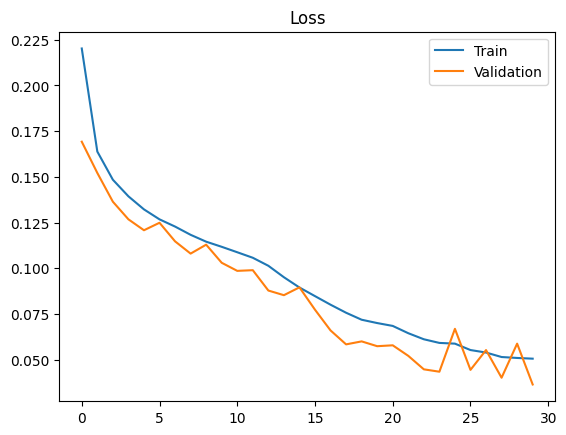

In [4]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

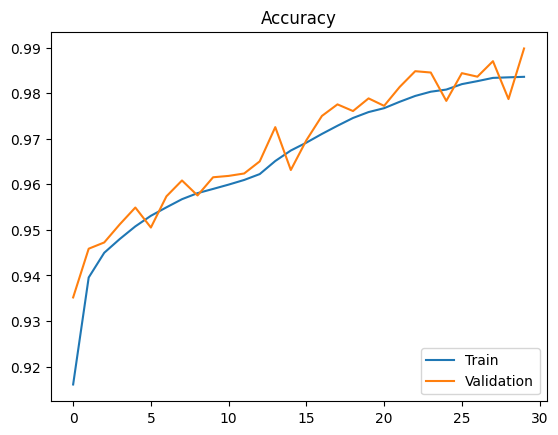

In [5]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [6]:
model = tf.keras.models.load_model('/kaggle/working/model_real_fake.keras')
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[40060:40070])
print("predictions shape:", predictions.shape)


Evaluate on test data
3338/3338 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9902 - loss: 0.0357
test loss, test acc: [0.03587757423520088, 0.9900808334350586]
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
predictions shape: (10, 2)


In [7]:
print(predictions)


[[8.7601650e-01 1.0897955e-01]
 [8.3760381e-01 1.4465232e-01]
 [9.9691463e-01 3.3250803e-03]
 [0.0000000e+00 1.0000000e+00]
 [3.1599317e-08 1.0000000e+00]
 [2.2310835e-05 9.9997616e-01]
 [6.2079616e-06 9.9999380e-01]
 [0.0000000e+00 1.0000000e+00]
 [4.5951150e-04 9.9948150e-01]
 [3.5555402e-04 9.9959558e-01]]


In [8]:
print(y_test[40060:40070])

[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


BENGIN = 0 và DDoS & Fake Flow = 1
Có thể thấy model nhận dạng đúng so với label cho trước với độ chính xác cao